In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from imblearn.over_sampling import RandomOverSampler


# EDA

In [62]:
df = pd.read_csv("C:\\D\\datasets\\Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [63]:
print(df.shape)

(10000, 14)


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


The data has no null values

In [65]:
df.drop(['RowNumber', 'CustomerId', 'HasCrCard', 'IsActiveMember', 'Exited'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


In [66]:
#checking for inbalanced data
ratio = df['Exited'].value_counts()
print(ratio)

Exited
0    7963
1    2037
Name: count, dtype: int64


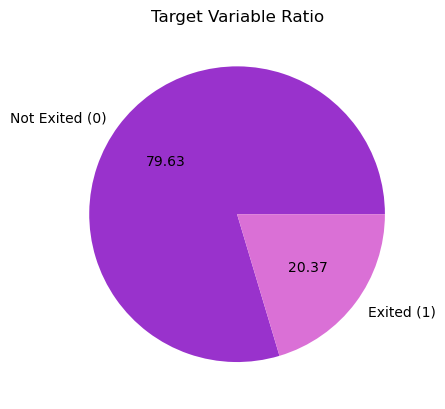

In [67]:
#Visualising the ratio
plt.pie(ratio.values, labels=['Not Exited (0)', 'Exited (1)'], autopct='%.2f', colors=['darkorchid', 'orchid'])
plt.title('Target Variable Ratio')
plt.show()

There is an obvious imbalance in the data

In [68]:
#checking for duplicated
df.duplicated().sum()

0

## Data Cleaning

In [69]:

df = df.drop(['RowNumber','Surname', 'CustomerId'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


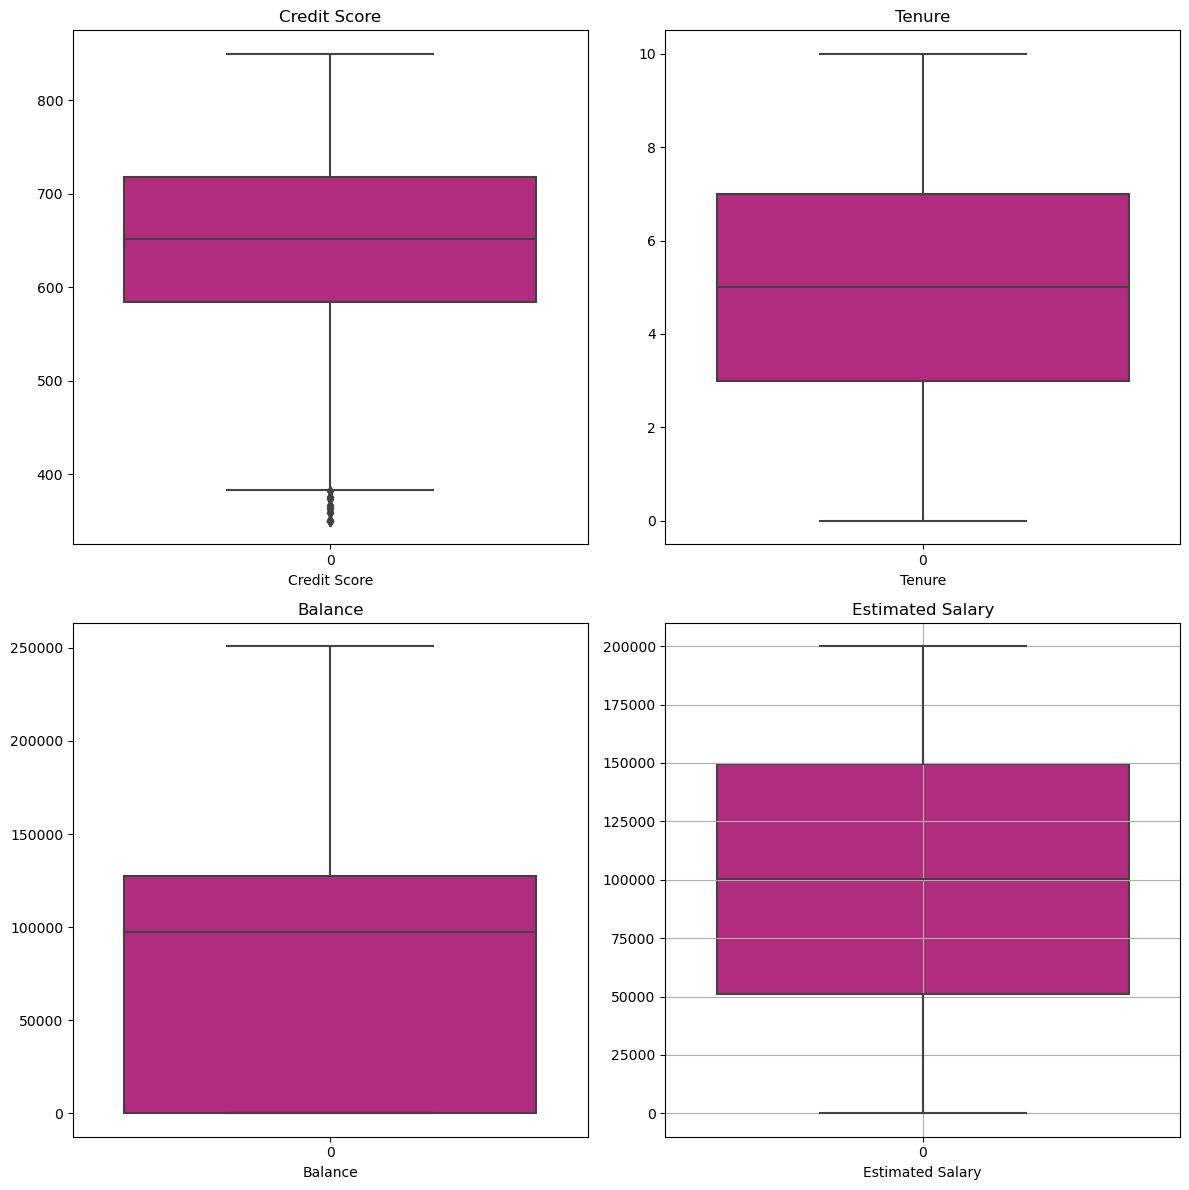

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
sns.boxplot(df['CreditScore'], color='mediumvioletred', ax=axs[0][0])
axs[0][0].set_xlabel("Credit Score")
axs[0][0].set_title("Credit Score")

sns.boxplot(df['Tenure'], color='mediumvioletred', ax=axs[0][1])
axs[0][1].set_xlabel("Tenure")
axs[0][1].set_title("Tenure")

sns.boxplot(df['Balance'], color='mediumvioletred', ax=axs[1][0])
axs[1][0].set_xlabel("Balance")
axs[1][0].set_title("Balance")

sns.boxplot(df['EstimatedSalary'], color='mediumvioletred', ax=axs[1][1])
axs[1][1].set_xlabel("Estimated Salary")
axs[1][1].set_title("Estimated Salary")

plt.grid(True)
plt.tight_layout()

Text(0.5, 1.0, 'Credit Score')

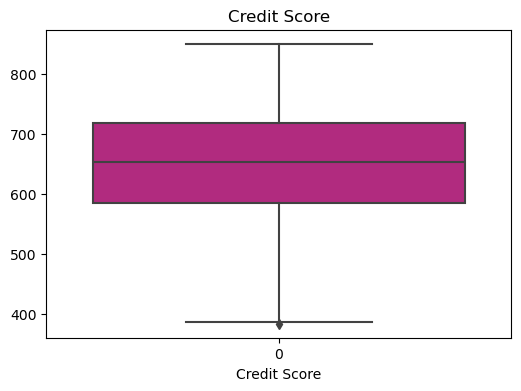

In [71]:
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Loop through each numerical column to remove outliers
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75)  
    IQR = Q3 - Q1  
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


plt.figure(figsize=(6, 4))  
sns.boxplot(df['CreditScore'], color='mediumvioletred')

plt.xlabel("Credit Score")
plt.title("Credit Score")

## Visualizations

Text(0.5, 0, 'Credit Card')

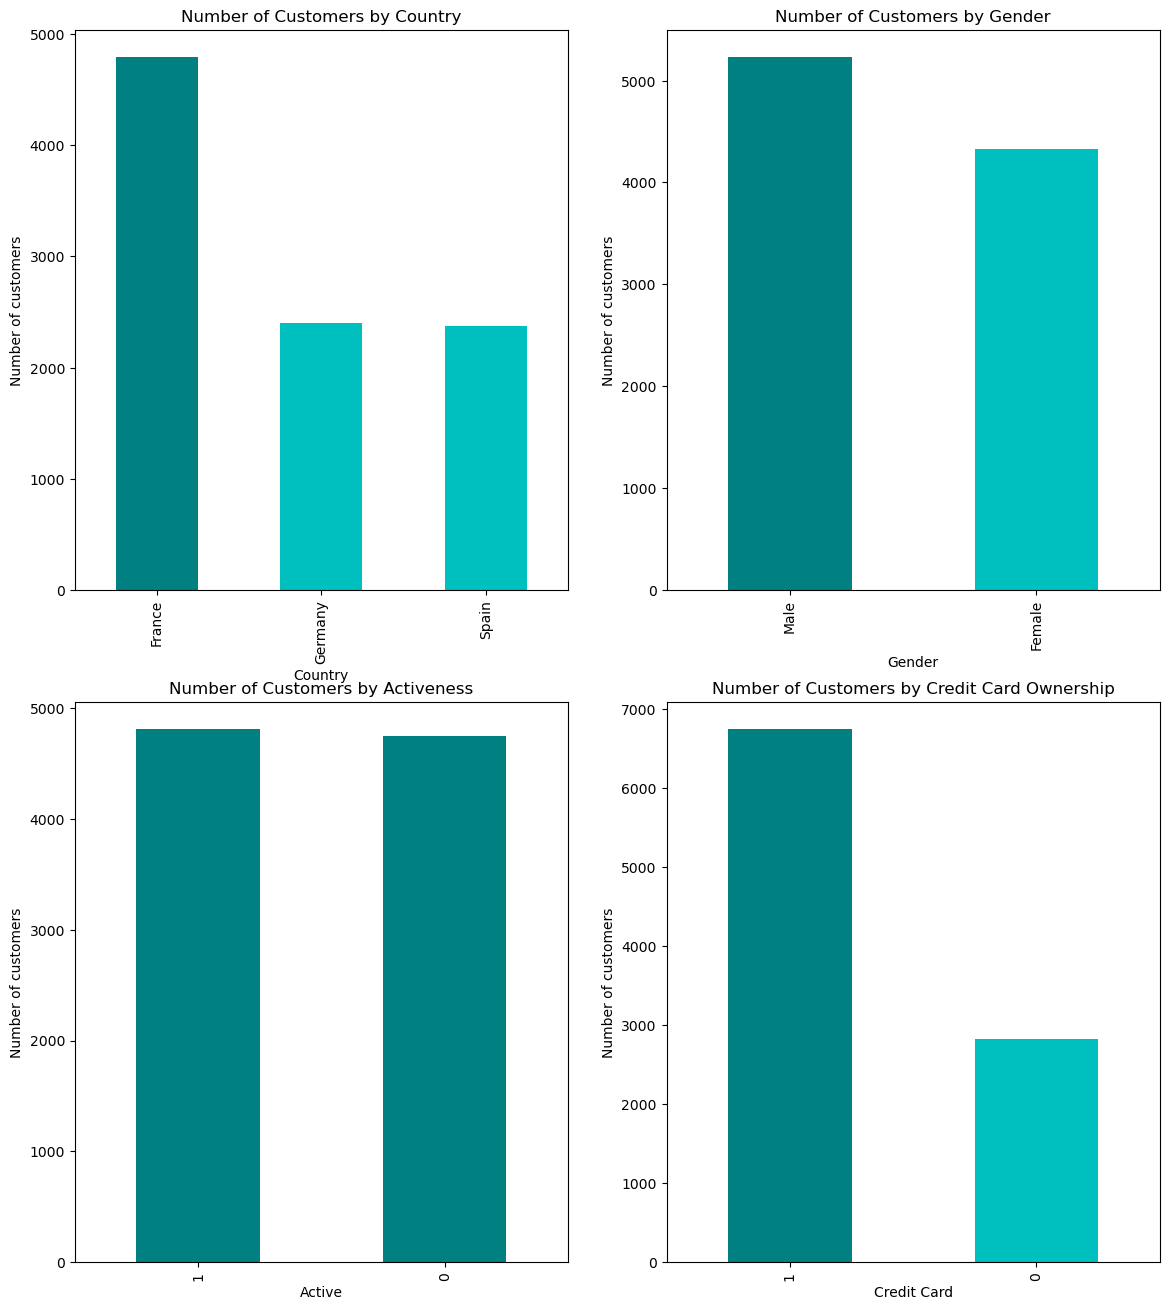

In [72]:
fig, axs = plt.subplots(2,2, figsize=(14, 16))

df.Geography.value_counts().plot(kind='bar', color=['teal','c','c'], ax=axs[0][0])
axs[0][0].set_title("Number of Customers by Country")
axs[0][0].set_ylabel('Number of customers')
axs[0][0].set_xlabel('Country')

df.Gender.value_counts().plot(kind='bar', color=['teal','c'], ax=axs[0][1])
axs[0][1].set_title("Number of Customers by Gender")
axs[0][1].set_ylabel('Number of customers')
axs[0][1].set_xlabel('Gender')

df.IsActiveMember.value_counts().plot(kind='bar', color='teal', ax=axs[1][0])
axs[1][0].set_title("Number of Customers by Activeness")
axs[1][0].set_ylabel('Number of customers')
axs[1][0].set_xlabel('Active')

df.HasCrCard.value_counts().plot(kind='bar', color=['teal','c'], ax=axs[1][1])
axs[1][1].set_title("Number of Customers by Credit Card Ownership")
axs[1][1].set_ylabel('Number of customers')
axs[1][1].set_xlabel('Credit Card')

## Hot one encoding

In [73]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
df = df.astype('int64')
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0


## Feature Scaling

In [74]:
#feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,0.505353,0.545455,0.2,0.000000,0.0,1.0,1.0,0.506733,1.0,0.0,0.0,0.0
1,0.481799,0.522727,0.1,0.334028,0.0,0.0,1.0,0.562708,0.0,0.0,1.0,0.0
2,0.254818,0.545455,0.8,0.636354,1.0,1.0,0.0,0.569654,1.0,0.0,0.0,0.0
3,0.676660,0.477273,0.1,0.000000,0.5,0.0,0.0,0.469120,0.0,0.0,0.0,0.0
4,1.000000,0.568182,0.2,0.500243,0.0,1.0,1.0,0.395403,0.0,0.0,1.0,0.0


We don't necessarily need scaled feature for a decision tree model but we will need it later for KNN

# Machine Learning Model

## Decision Tree

In [75]:
# splitting the data
X = scaled_df.drop('Exited', axis=1)
y = scaled_df['Exited']

#split the data into training set and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

#splitting the temporary set into validation set and test set
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12, stratify=y_temp)

In [76]:
tree = DecisionTreeClassifier(max_depth=5)

#train the model
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [77]:
y_pred = tree.predict(X_val)

accuracy = round(accuracy_score(y_val, y_pred),2)
print(f"Accuracy: {accuracy}")
precision = round(precision_score(y_val, y_pred),2)
print(f"Precision: {precision}")
recall = round(recall_score(y_val, y_pred),2)
print(f"Recall: {recall}")
f1 = round(f1_score(y_val, y_pred),2)
print(f"F1-Score: {f1}")

Accuracy: 0.85
Precision: 0.69
Recall: 0.42
F1-Score: 0.52


**Recall:** `42%`

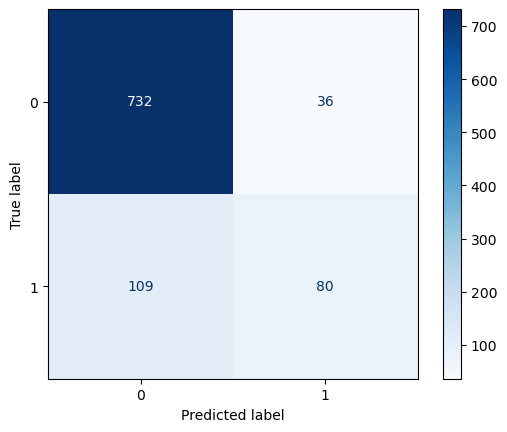

In [78]:
conf_mat = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(conf_mat) 
disp.plot(cmap='Blues') 
plt.show()

In [79]:
grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, {0: 1, 1: 5}, 'balanced']
}
grid_search = GridSearchCV(estimator=tree, param_grid=grid,
                            scoring='recall',  cv=5, verbose=1, n_jobs=-1)

In [80]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=5), n_jobs=-1,
             param_grid={'class_weight': [None, {0: 1, 1: 5}, 'balanced'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall', verbose=1)

In [81]:
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Recall:", grid_search.best_score_)

print("Best Model Accuracy: ", best_model.score(X_val, y_val))

Best Parameters: {'class_weight': {0: 1, 1: 5}, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Cross-Validation Recall: 0.7984285183485236
Best Model Accuracy:  0.7836990595611285


In [82]:
y_pred = best_model.predict(X_test)

#evaluation metrics
accuracy = round(accuracy_score(y_test, y_pred),2)
print(f"Accuracy: {accuracy}")
precision = round(precision_score(y_test, y_pred),2)
print(f"Precision: {precision}")
recall = round(recall_score(y_test, y_pred),2)
print(f"Recall: {recall}")
f1 = round(f1_score(y_test, y_pred),2)
print(f"F1-Score: {f1}")

Accuracy: 0.77
Precision: 0.45
Recall: 0.7
F1-Score: 0.55


**Recall:** `70%`

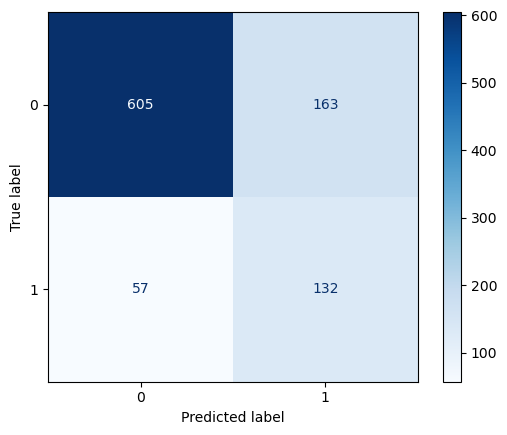

In [83]:
#Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot(cmap='Blues') 
plt.show()

## KNN

Now we will use similarity measures to train an ML model

Applying oversampling techeniques to help balance the data.

In [84]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [85]:
#Splitting the data 80% training set and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

Training three different knn models using 3 different distance metrics

In [86]:
#Euclidean
knn = KNeighborsClassifier(n_neighbors=50)
param_grid = {'n_neighbors': range(1, 10)}
grid = GridSearchCV(knn, param_grid, scoring='recall', cv=5)
grid.fit(X_train, y_train)
knn_euclidean = grid.best_estimator_


In [87]:

#Manhattan
knn = KNeighborsClassifier(n_neighbors=50, metric='manhattan')
grid = GridSearchCV(knn, param_grid, scoring='recall', cv=5)
grid.fit(X_train, y_train)
knn_manhattan = grid.best_estimator_


In [88]:

#Minkowski
knn = KNeighborsClassifier(n_neighbors=50, metric='minkowski')
grid = GridSearchCV(knn, {
    'n_neighbors': range(1, 11),
    'p': range(1, 6)
}, scoring='recall', cv=5)
grid.fit(X_train, y_train)
knn_minkowski = grid.best_estimator_


In [89]:
models = [knn_euclidean, knn_manhattan, knn_minkowski]
model_names = ["Euclidean", "Manhattan", "Minkowski"]
recalls = []
for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    print(f"\033[1m{name}'s metrics\033[0m")
    accuracy = round(accuracy_score(y_test, y_pred),2)
    print(f"Accuracy: {accuracy}")
    precision = round(precision_score(y_test, y_pred),2)
    print(f"Precision: {precision}")
    recall = round(recall_score(y_test, y_pred),2)
    recalls.append(recall)
    print(f"Recall: {recall}")
    f1 = round(f1_score(y_test, y_pred),2)
    print(f"F1-Score: {f1}")
    print()

Euclidean's metrics
Accuracy: 0.92
Precision: 0.88
Recall: 0.98
F1-Score: 0.93

Manhattan's metrics
Accuracy: 0.93
Precision: 0.89
Recall: 0.98
F1-Score: 0.93

Minkowski's metrics
Accuracy: 0.92
Precision: 0.87
Recall: 0.98
F1-Score: 0.92



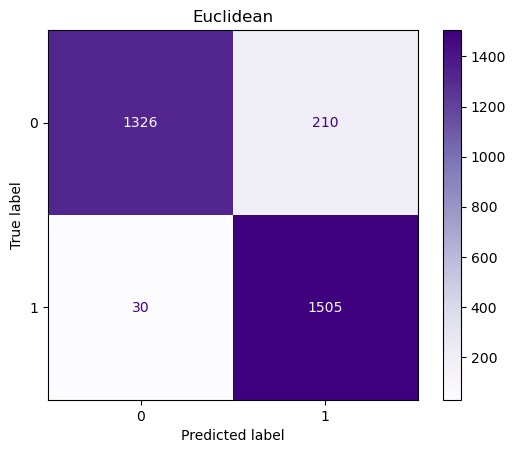

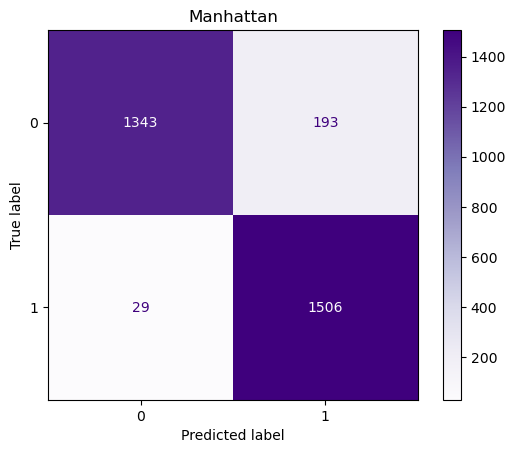

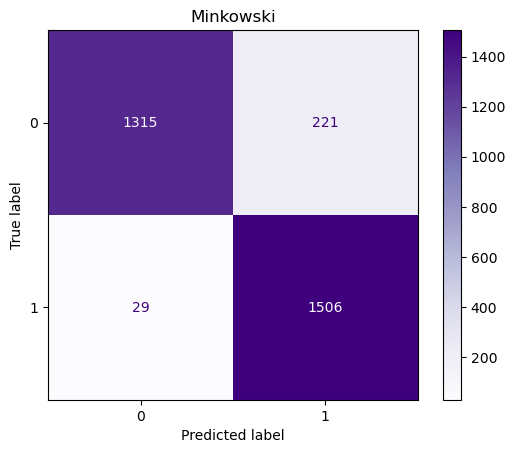

In [90]:

# Iterate over models
for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot(cmap='Purples')
    plt.title(f"{name}")
